In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import urllib.request

np.random.seed(seed=0)

In [2]:
data_path = "../data/"

df = pd.read_csv(data_path + "reviews.csv", nrows=100000)
print(df.head(3))
print(len(df))

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
100000


# Data Preprocessing

In [3]:
df = df[['Summary', 'Text']] # use only two columns
print(df.head(3))

                 Summary                                               Text
0  Good Quality Dog Food  I have bought several of the Vitality canned d...
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...
2  "Delight" says it all  This is a confection that has been around a fe...


In [4]:
# check null and duplicate
print(df.isnull().sum())
print(df.nunique())

df = df.dropna()
df = df.drop_duplicates(subset=['Text']) # drop duplicates in Text column
print(len(df))

Summary    2
Text       0
dtype: int64
Summary    72348
Text       88426
dtype: int64
88425


In [5]:
contractions = {"'cause": 'because',
                "I'd": 'I would',
                "I'd've": 'I would have',
                "I'll": 'I will',
                "I'll've": 'I will have',
                "I'm": 'I am',
                "I've": 'I have',
                "ain't": 'is not',
                "aren't": 'are not',
                "can't": 'cannot',
                "could've": 'could have',
                "couldn't": 'could not',
                "didn't": 'did not',
                "doesn't": 'does not',
                "don't": 'do not',
                "hadn't": 'had not',
                "hasn't": 'has not',
                "haven't": 'have not',
                "he'd": 'he would',
                "he'll": 'he will',
                "he's": 'he is',
                "here's": 'here is',
                "how'd": 'how did',
                "how'd'y": 'how do you',
                "how'll": 'how will',
                "how's": 'how is',
                "i'd": 'i would',
                "i'd've": 'i would have',
                "i'll": 'i will',
                "i'll've": 'i will have',
                "i'm": 'i am',
                "i've": 'i have',
                "isn't": 'is not',
                "it'd": 'it would',
                "it'd've": 'it would have',
                "it'll": 'it will',
                "it'll've": 'it will have',
                "it's": 'it is',
                "let's": 'let us',
                "ma'am": 'madam',
                "mayn't": 'may not',
                "might've": 'might have',
                "mightn't": 'might not',
                "mightn't've": 'might not have',
                "must've": 'must have',
                "mustn't": 'must not',
                "mustn't've": 'must not have',
                "needn't": 'need not',
                "needn't've": 'need not have',
                "o'clock": 'of the clock',
                "oughtn't": 'ought not',
                "oughtn't've": 'ought not have',
                "sha'n't": 'shall not',
                "shan't": 'shall not',
                "shan't've": 'shall not have',
                "she'd": 'she would',
                "she'd've": 'she would have',
                "she'll": 'she will',
                "she'll've": 'she will have',
                "she's": 'she is',
                "should've": 'should have',
                "shouldn't": 'should not',
                "shouldn't've": 'should not have',
                "so's": 'so as',
                "so've": 'so have',
                "that'd": 'that would',
                "that'd've": 'that would have',
                "that's": 'that is',
                "there'd": 'there would',
                "there'd've": 'there would have',
                "there's": 'there is',
                "they'd": 'they would',
                "they'd've": 'they would have',
                "they'll": 'they will',
                "they'll've": 'they will have',
                "they're": 'they are',
                "they've": 'they have',
                "this's": 'this is',
                "to've": 'to have',
                "wasn't": 'was not',
                "we'd": 'we would',
                "we'd've": 'we would have',
                "we'll": 'we will',
                "we'll've": 'we will have',
                "we're": 'we are',
                "we've": 'we have',
                "weren't": 'were not',
                "what'll": 'what will',
                "what'll've": 'what will have',
                "what're": 'what are',
                "what's": 'what is',
                "what've": 'what have',
                "when's": 'when is',
                "when've": 'when have',
                "where'd": 'where did',
                "where's": 'where is',
                "where've": 'where have',
                "who'll": 'who will',
                "who'll've": 'who will have',
                "who's": 'who is',
                "who've": 'who have',
                "why's": 'why is',
                "why've": 'why have',
                "will've": 'will have',
                "won't": 'will not',
                "won't've": 'will not have',
                "would've": 'would have',
                "wouldn't": 'would not',
                "wouldn't've": 'would not have',
                "y'all": 'you all',
                "y'all'd": 'you all would',
                "y'all'd've": 'you all would have',
                "y'all're": 'you all are',
                "y'all've": 'you all have',
                "you'd": 'you would',
                "you'd've": 'you would have',
                "you'll": 'you will',
                "you'll've": 'you will have',
                "you're": 'you are',
                "you've": 'you have'}

In [6]:
# stopwords
stopwords = set(stopwords.words('english'))
print(len(stopwords))

179


In [7]:
def preprocess_sentence(sentence, is_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, features='lxml').text
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 e.g.,) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) 
    sentence = ' '.join([contractions[word] if word in contractions else word for word in sentence.split()])
    sentence = re.sub(r"'s\b","",sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    if is_stopwords:
        tokens = ' '.join([word for word in sentence.split() if not word in stopwords if len(word) > 1])
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens

# test
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [8]:
clean_text = []
for sentence in df['Text']:
    clean_sentence = preprocess_sentence(sentence)
    clean_text.append(clean_sentence)
    
df['Text'] = clean_text
    
clean_summary = []
for sentence in df['Summary']:
    clean_sentence = preprocess_sentence(sentence, 0)
    clean_summary.append(clean_sentence)
    
df['Summary'] = clean_summary
    
df.head(5)

<ipython-input-7-6c217c7be6b7>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, features='lxml').text
<ipython-input-7-6c217c7be6b7>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  sentence = BeautifulSoup(sentence, features='lxml').text


,Summary,Text
0,good quality dog food,bought several vitality canned dog food produc...
1,not as advertised,product arrived labeled jumbo salted peanuts p...
2,delight says it all,confection around centuries light pillowy citr...
3,cough medicine,looking secret ingredient robitussin believe f...
4,great taffy,great taffy great price wide assortment yummy ...


In [9]:
# check null and duplicate again
print(df.isnull().sum())
print(df.nunique())
print(len(df))

df = df.drop_duplicates(subset=['Text'])
print(len(df))

Summary    0
Text       0
dtype: int64
Summary    62801
Text       88350
dtype: int64
88425
88350


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.789620826259195
요약의 최소 길이 : 0
요약의 최대 길이 : 28
요약의 평균 길이 : 4.006191284663271


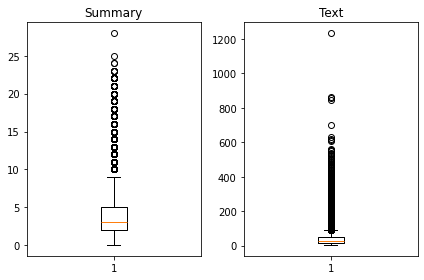

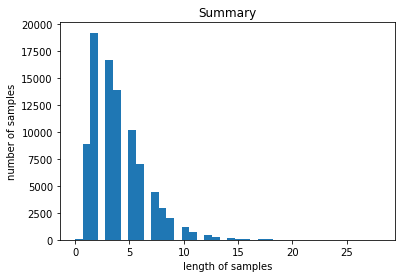

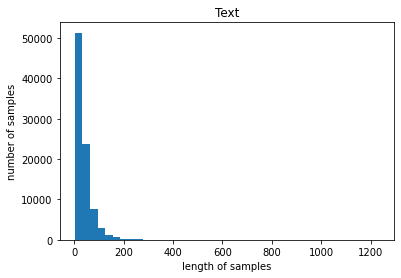

In [10]:
# 길이 분포 출력
text_len = [len(s.split()) for s in df['Text']]
summary_len = [len(s.split()) for s in df['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
text_max_len = 50
summary_max_len = 8

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


below_threshold_len(text_max_len, df['Text'])
below_threshold_len(summary_max_len, df['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7746576117713639
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9426372382569327


In [12]:
df = df[df['Text'].apply(lambda row: len(row.split()) <= text_max_len)]
df = df[df['Summary'].apply(lambda row: len(row.split()) <= summary_max_len)]

print(len(df))
print(df.head(5))

65828
                 Summary                                               Text
0  good quality dog food  bought several vitality canned dog food produc...
1      not as advertised  product arrived labeled jumbo salted peanuts p...
2    delight says it all  confection around centuries light pillowy citr...
3         cough medicine  looking secret ingredient robitussin believe f...
4            great taffy  great taffy great price wide assortment yummy ...


### df[...]:
 - boolean indexing operation on the DataFrame df. The inner operation creates a boolean series, where each value is True if the condition is met (i.e., the text length is within the limit) and False otherwise.The df is then indexed with this boolean series, resulting in a new DataFrame that only contains rows where the condition is True.

# Tokenizing

In [13]:
df['decoder_input'] = df['Summary'].apply(lambda s: 'sostoken '+ s)
df['decoder_target'] = df['Summary'].apply(lambda s: s + ' eostoken')

encoder_input = np.array(df['Text'])
decoder_input = np.array(df['decoder_input'])
decoder_target = np.array(df['decoder_target'])

df.head(5)

,Summary,Text,decoder_input,decoder_target
0,good quality dog food,bought several vitality canned dog food produc...,sostoken good quality dog food,good quality dog food eostoken
1,not as advertised,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised,not as advertised eostoken
2,delight says it all,confection around centuries light pillowy citr...,sostoken delight says it all,delight says it all eostoken
3,cough medicine,looking secret ingredient robitussin believe f...,sostoken cough medicine,cough medicine eostoken
4,great taffy,great taffy great price wide assortment yummy ...,sostoken great taffy,great taffy eostoken


In [14]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

[29466 29593 29630 ... 45891 42613 43567]
테스트 데이터의 수 : 13165
훈련 데이터의 개수 : 52663
훈련 레이블의 개수 : 52663
테스트 데이터의 개수 : 13165
테스트 레이블의 개수 : 13165


In [15]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

print(src_tokenizer.word_index['gap'], src_tokenizer.index_word[11309]) # check index of word
print(src_tokenizer.word_counts['home']) # check frequency of word

11309 gap
1155


In [16]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32081
등장 빈도가 6번 이하인 희귀 단어의 수: 23821
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8260
단어 집합에서 희귀 단어의 비율: 74.25267292166703
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.394822959978698


In [17]:
# remove rare words
src_vocab = 8500
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

# integer encoding
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[242, 12, 1303, 1841, 5287, 19, 77, 762, 19, 2809, 818, 22, 2095, 130, 7682, 10, 1081, 101, 1860, 4170, 818, 762, 19, 3, 16, 242, 6], [41, 1, 1633, 666, 1528, 157, 626, 294, 1070, 150, 917, 1574, 1382, 324, 6, 498, 205, 967, 100, 7182, 5112, 205, 1181, 4, 58, 273, 899, 3], [4272, 1968, 175, 2648, 76, 113, 51, 920, 335, 93, 340, 36, 192, 86, 14, 243, 239, 41, 2, 1929, 407, 784, 180, 556, 14, 108, 231, 7183, 867, 166, 20, 517, 161, 51, 645, 296, 14]]


In [18]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

print(tar_tokenizer.word_index['home'], tar_tokenizer.index_word[337])
print(tar_tokenizer.word_counts['home'])

337 home
77


In [19]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10442
등장 빈도가 5번 이하인 희귀 단어의 수: 8047
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2395
단어 집합에서 희귀 단어의 비율: 77.06378088488796
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.843161775803704


In [20]:
# remove rare words
tar_vocab = 2400
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train) 
tar_tokenizer.fit_on_texts(decoder_target_train)

# integer encoding
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print(decoder_input_train[:5])
print(decoder_target_train[:5])

[[1, 219, 619], [1, 80, 1153, 54], [1, 11, 32], [1, 271, 20], [1, 49, 147]]
[[219, 619, 2], [80, 1153, 54, 2], [11, 32, 2], [271, 20, 2], [49, 147, 2]]


In [21]:
# finding empty sample indices
print(len(encoder_input_train), len(decoder_input_train), len(decoder_target_train), len(encoder_input_test), len(decoder_input_test), len(decoder_target_test))

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

# padding
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')

encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# drop
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print(len(encoder_input_train), len(decoder_input_train), len(decoder_target_train), len(encoder_input_test), len(decoder_input_test), len(decoder_target_test))

52663 52663 52663 13165 13165 13165
51546 51546 51546 12858 12858 12858


# Modeling

In [22]:
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Encoder

In [23]:
# hyperparameters
embedding_dim = 128
hidden_units = 256
dropout_ratio = 0.4

enc_input = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(enc_input)

# lstm
encoder_outputs_layer_1 = LSTM(units=hidden_units, return_state=False, return_sequences=True, dropout=dropout_ratio, recurrent_dropout=dropout_ratio)
encoder_outputs_1 = encoder_outputs_layer_1(enc_emb)

encoder_outputs_layer_2 = LSTM(units=hidden_units, return_state=False, return_sequences=True, dropout=dropout_ratio, recurrent_dropout=dropout_ratio)
encoder_outputs_2 = encoder_outputs_layer_2(encoder_outputs_1)

encoder_outputs_layer_fin = LSTM(units=hidden_units, return_state=True, return_sequences=True, dropout=dropout_ratio, recurrent_dropout=dropout_ratio)
encoder_outputs, state_h, state_c = encoder_outputs_layer_fin(encoder_outputs_2)

# Decoder

In [38]:
dec_input = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(dec_input)

# lstm
decoder_lstm = LSTM(units=hidden_units, return_state=True, return_sequences=True, dropout=dropout_ratio, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [25]:
# using attention layer instead of this part.
# 
# # softmax
# decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
# decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)
# 
# # model
# model = Model([enc_input, dec_input], decoder_softmax_outputs)
# model.summary()

## Attention 

In [26]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer

In [27]:
# Bahdanau AttentionLayer code from outsource.
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [28]:
attention_layer = AttentionLayer(name='attention_layer')

attention_out, attention_states = attention_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_out])

# softmax
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# model
model = Model([enc_input, dec_input], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 128)              1088000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 50, 256)              394240    ['embedding[0][0]']           
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                              

In [29]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = 256, callbacks=[es], epochs = 1)

202/202 [==============================] - 352s 2s/step - loss: 2.7726 - val_loss: 2.4972


# Inferencing

In [44]:
src_word_index = src_tokenizer.word_index
src_index_word = src_tokenizer.index_word
tar_word_index = tar_tokenizer.word_index
tar_index_word = tar_tokenizer.index_word

# Encoder

In [31]:
# encoder
# get all encoder layers from 'enc_input' to [encoder_outputs, state_h, state_c]
enc_model_inf = Model(inputs=enc_input, outputs=[encoder_outputs, state_h, state_c])
enc_model_inf.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 128)           1088000   
                                                                 
 lstm (LSTM)                 (None, 50, 256)           394240    
                                                                 
 lstm_1 (LSTM)               (None, 50, 256)           525312    
                                                                 
 lstm_2 (LSTM)               [(None, 50, 256),         525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 2532864 (9.66 MB)
Trainable params: 2532864 (

## Decoder

In [39]:
# save previous states
# previous states will be injected in 'decode_sequence' function
dec_inf_input_h = Input(shape=(hidden_units,))
dec_inf_input_c = Input(shape=(hidden_units,))

dec_inf_emb = dec_emb_layer(dec_input) # dec_input = Input(shape=(None,)

dec_inf_output, dec_inf_state_h, dec_inf_state_c = decoder_lstm(dec_inf_emb, initial_state=[dec_inf_input_h, dec_inf_input_c])

In [40]:
dec_inf_hidden_input = Input(shape=(text_max_len, hidden_units)) # encoder output = ('encoder_outputs')
dec_inf_attention_out, dec_inf_attention_states = attention_layer([dec_inf_hidden_input, dec_inf_output])
dec_inf_concat = Concatenate(axis=-1, name='concat')([dec_inf_output, dec_inf_attention_out])

dec_inf_output_layer = decoder_softmax_layer(dec_inf_concat)

dec_inf_model = Model(
    inputs=[dec_input] + [dec_inf_hidden_input, dec_inf_input_h, dec_inf_input_c],
    outputs=[dec_inf_output_layer] + [dec_inf_state_h, dec_inf_state_c]
)

dec_inf_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, None, 128)            307200    ['input_9[0][0]']             
                                                                                                  
 input_10 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 256)]                0         []                            
                                                                                            

In [43]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = enc_model_inf.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = dec_inf_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # -1 : last time step
        sampled_token = tar_index_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


In [45]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    sentence=''
    for i in input_seq:
        if(i!=0):
            sentence = sentence + src_index_word[i]+' '
    return sentence

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_index['sostoken']) and i!=tar_word_index['eostoken']):
            sentence = sentence + tar_index_word[i] + ' '
    return sentence


In [46]:
for i in range(500, 503):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  bought cheaper alternative le de de bad stick le product find 
실제 요약문 : not bad but 
1/1 [==============================] - 0s 11ms/step
예측 요약문 :  great great great great great great great


원문 :  like product much healthy alternative greasy pork sausages bacon morning especially good grits eggs bit butter drop hot sauce try believe like 
실제 요약문 : product 
1/1 [==============================] - 0s 10ms/step
예측 요약문 :  my my my my my my not


원문 :  purchased paramount oz popcorn maker figuring would easy quick mess however half kernals popped thats gave lower review flavor mark movie theater taste perfect salt butter flavor opinion wish kernals popped 
실제 요약문 : movie theater popcorn 
1/1 [==============================] - 0s 10ms/step
예측 요약문 :  great great my my my great great

